## EWAS finding optimum number of cpgs for Ridge regression
DC

#### This notebook contains code to:

* Specify a tissue of interst from the EWAS Aging dataset.
* Load the EWAS aging text data file (age_methylation_v1.txt).
* Rewrite it to a new csv file with just the samples from the tissue of interest.
* Read back in to a dataframe in chunks the written file and combine the chunks into a new dataframe.
* Transpose the dataframe so cpgs are the columns.
* Add back columns for age and tissue.
* Select only samples with age over 20.
* Split data 75/25, working / saved. 
* Drop all cpgs columns with more than 75% NAs in working data.
* Fill remaining NAs with the mean for each column in working data.
* Drop same columns in the Saved data as where droppped in the working data.
* Fill remaining NAs in the saved data with the mean for each column in the working data.
* Write dataframe to file if desired
* Then run XGboost cross val 50 times
* Find top 100 cpgs
* Model with those linear, ridge, lasso, XGboost
* Test models on saved data
* Run lasso many times to look at consistance of coefficients

### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [2]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [3]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')

### Set Tissue of Interest

In [4]:
# This is the search term used to select the samples from the tissue of interest.
# The function below will select all samples with the search term in the tissue row.
# If the search term appears in any part of the tissue row, that row will be included.
tissue_of_interest = 'whole blood'

### Function for loading the age_methylation_v1.txt data file and writing a subset file by tissue. It uses the csv package for speed instead of pandas

In [5]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containing only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')

In [6]:
def test_model_on_heldout_data(X_saved, y_saved, model, mtype='Linear Regression', figsize=(8,4), xlim=None):
    
    # Using  model to make predictions on saved data
    preds_on_saved = model.predict(X_saved)
    MSE_test = mean_squared_error(y_saved, preds_on_saved)
    rms_test = (mean_squared_error(y_saved, preds_on_saved))**0.5
    r2_test = r2_score(y_saved, preds_on_saved)
    MAE_test = mean_absolute_error(y_saved, preds_on_saved)
    r_test_corr = np.corrcoef(y_saved, preds_on_saved)[0,1] # preds_on_saved
    
    # Plotting results
    model_type = mtype

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.scatter(y_saved, preds_on_saved, alpha=0.5)
    ax.plot(range(20,100), range(20,100), c='red')
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)
    ax.set_xlabel('True Age')
    if xlim !=None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel('Predicted Age')
    ax.grid(True, lw=1.5, ls='--', alpha=0.75)
    ax.set_title(f'{model_type} on Held Out data')
    plt.show()

    # print metric
    print(f'The MSE on the saved data is {MSE_test:.3f} years')
    print(f'The rms on the saved data is {rms_test:.3f} years')
    print(f'The r^2 on the saved data is {r2_test:.3f}')
    print(f'The mae on the saved data is {MAE_test:.3f} years')
    print(f'The correlation on the held out data true-predicted is {r_test_corr:.3f}')
    
    return preds_on_saved, MSE_test, rms_test, r2_test, MAE_test, r_test_corr

In [7]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].set_xlim(0, 120)
        ax[0].set_ylim(0, 120)
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].set_xlim(0, 120)
        ax[1].set_ylim(0, 120)
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [8]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
    
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(16,3.5))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].set_xlim(0, 120)
        ax[0].set_ylim(0, 120)
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].set_xlim(0, 120)
        ax[1].set_ylim(0, 120)
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

In [9]:
# Function for running a ridge Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import RidgeCV
def ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = RidgeCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].set_xlim(0, 120)
        ax[0].set_ylim(0, 120)
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Ridge Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].set_xlim(0, 120)
        ax[1].set_ylim(0, 120)
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [10]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].set_xlim(0, 120)
        ax[0].set_ylim(0, 120)
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].set_xlim(0, 120)
        ax[1].set_ylim(0, 120)
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAE on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    print(f'Optimal alpha from CV = {mod.alpha_}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [11]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost(df_processed, numtrials, early_stopping_rounds = 10, test_size=0.20):
    X = df_processed.iloc[:,2:]
    y = df_processed.age
    importances = []
    rms_train = []
    rms_test = []
    r2_train = []
    r2_test = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        rms_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rms_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[2:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, rms_train, rms_test, r2_train, r2_test

# Takes df of importance scores produced by repeat_XGBoost and sorts by mean imp score
def importances_sorted_by_mean(df_imp):
    df_imp_sorted = df_imp.sort_values('Mean', ascending=False)
    return df_imp_sorted

# Makes a histogram of the frequecy of cgs in the top (top_num) importance scores
def histogram_of_top_CpGs_by_importance(df_imp, top_num=20):
    vs = []
    inds = []
    for col in df_imp.columns[:-2]:
        c = df_imp[col].sort_values(ascending=False)
        vs.append(c[:top_num])
        inds  = inds + list(c.index[:top_num])
    h = pd.Series(inds).value_counts()
    # Plotting the first 100 importance scores
    plt.figure(figsize = (30, 12))
    plt.bar(h.index[:100],h[:100])
    plt.title('Frequency of CpGs in the top 100 importances')
    plt.ylabel('Frequency')
    plt.xlabel('CpG')
    plt.xticks(fontsize = 16, rotation=90)
    plt.show()
    return inds, vs, h

## Loading Data to dataframe

### Read data file and write new file with data from the selected tissue

In [12]:
%%time
# Writing data to a file with the above function selecting out a certain tissue
file_out = './age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', file_out, tissue_of_interest, num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000
C

### Read back in data in chunks and combine to new dataframe

In [13]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv(file_out, header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

CPU times: user 1min 15s, sys: 4.27 s, total: 1min 19s
Wall time: 1min 22s


In [14]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

CPU times: user 5 s, sys: 17.1 s, total: 22.1 s
Wall time: 1min 4s


### Transpose dataframe so cpgs are columns. Then add columns for age and tissue saved from the write operation

In [15]:
%%time
# transposing dataframe
df_t = df.transpose()

CPU times: user 4.72 ms, sys: 21 ms, total: 25.8 ms
Wall time: 61.6 ms


In [16]:
# Inserting columns for tissue and age and setting age dtype to float and then rounding to int
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')

In [17]:
df_t.shape

(1802, 485514)

### Selecting out samples with ages over 20 years old

In [18]:
# Selecting out samples with age > 20
df_processed_over20 = df_t[df_t.age >=20]

### Dividing data into working and saved sets (75/25 split)

In [19]:
df_processed_over20.shape

(1422, 485514)

In [20]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_over20.shape[0]
num_for_saving = int(round(df_processed_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_over20.iloc[saved_index, :]
df_p_working = df_processed_over20.iloc[keep_index, :]

### Dealing with NAs in working data

#### Remove columns in working data with more than 25% NAs, Impute the rest with mean of columns

CPU times: user 2.13 s, sys: 4.49 s, total: 6.62 s
Wall time: 10.4 s


Text(0, 0.5, 'count')

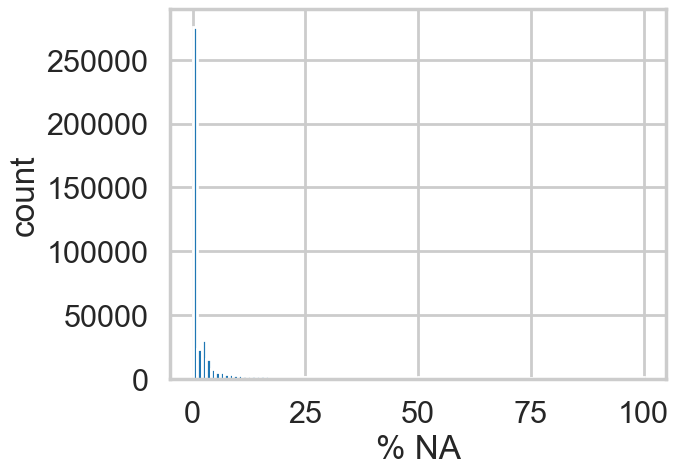

In [21]:
%%time
#looking at a histogram of the percent NAs for the columns
num_nans_hist = 100 * df_p_working.isna().sum(axis=0)/df_p_working.shape[0]
num_nans_hist.hist(bins=100)
plt.xlabel('% NA')
plt.ylabel('count')
#plt.ylim(0,50000)

#### Drop all columns with  NAs > 25% of values , then imput with mean of column

In [22]:
# remove columns with more than 10% NAs
df_p_working_imp = df_p_working.dropna(thresh = 0.90*df_p_working.shape[0], axis=1)

In [23]:
df_p_working_imp.shape

(1066, 375603)

In [24]:
%%time
# Impute all values with column mean
working_column_means = df_p_working_imp.mean()
df_p_working_imp = df_p_working_imp.fillna(working_column_means)

CPU times: user 3min 24s, sys: 2min 22s, total: 5min 46s
Wall time: 12min 5s


In [25]:
df_p_working_imp.isna().sum().sum()

0

### Now imputing saved data based on means of working data

In [26]:
# keep only the same columns as in the imputed working data
df_p_saved_imp = df_p_saved[df_p_working_imp.columns]

In [27]:
# impute wit the means of the working data
df_p_saved_imp = df_p_saved_imp.fillna(working_column_means)

### Writing final dataframe to a file (uncomment and set file to write)

In [28]:
%%time
# write dataframe to a csv file
#file_to_write = 'df_EWAS_aging_whole_blood_Imputated_lt75NaN_mean'
#df_processed_imp.to_csv(file_to_write)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.1 µs


### Histogram of ages in data

In [29]:
plt.rcdefaults()

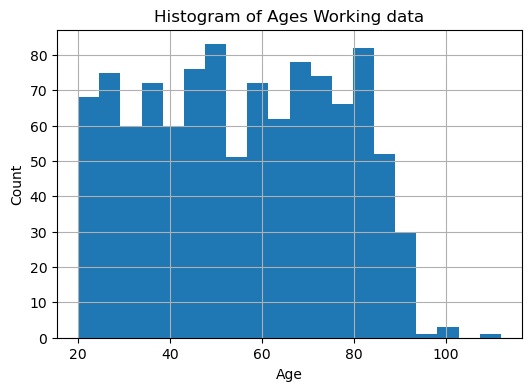

In [30]:
# Histogram of ages in working data
plt.figure(figsize=(6,4))
df_p_working_imp.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Working data')
plt.show()

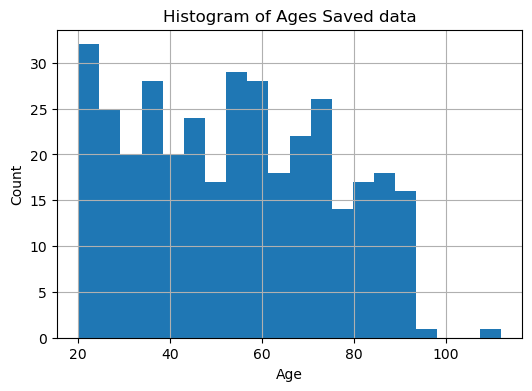

In [31]:
# Histogram of ages in saved data
plt.figure(figsize=(6,4))
df_p_saved_imp.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages Saved data')
plt.show()

In [32]:
df_p_working_imp

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00016522,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00391044,cg00399450,cg00408231,cg00412010,cg00412368,cg00416689,cg00427681,cg00457389,cg00458505,...,cg27545494,cg27552198,cg27553637,cg27575890,cg27585287,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2334366,whole blood,94,0.078,0.205,0.139,0.904,0.120,0.970,0.912,0.276,0.616,0.602,0.577,0.612,0.888,0.551,0.415,0.112,0.672,0.526,0.641,0.367000,0.630,0.561,0.485,0.579,0.662,0.635,0.449,0.480,0.256,0.288,0.522,0.616,0.602,0.583,0.519,0.019,0.900,0.607,0.017,0.397,0.577,0.532,0.448,0.653,0.266,0.388,0.156,0.583,...,0.008,0.962,0.078,0.451,0.022,0.943,0.94800,0.962,0.064000,0.953,0.020,0.035,0.977,0.975,0.924,0.087,0.096,0.023000,0.882,0.001000,0.002000,0.012000,0.160,0.013,0.121,0.016,0.003000,0.014000,0.011,0.002,0.008,0.014000,0.009,0.018000,0.009000,0.017,0.005,0.010,0.045,0.011,0.109,0.016,0.003,0.006000,0.010000,0.004,0.010,0.001000,0.047,0.012
GSM989863,whole blood,101,0.013,0.008,0.117,0.756,0.033,0.958,0.933,0.324,0.509,0.519,0.529,0.629,0.955,0.490,0.318,0.072,0.664,0.569,0.594,0.475000,0.575,0.533,0.420,0.566,0.558,0.520,0.201,0.453,0.293,0.473,0.454,0.434,0.589,0.443,0.401,0.014,0.873,0.473,0.007,0.471,0.554,0.678,0.447,0.513,0.270,0.468,0.129,0.553,...,0.012,0.952,0.050,0.329,0.014,0.907,0.95200,0.967,0.067000,0.649,0.032,0.028,0.967,0.969,0.851,0.093,0.067,0.023000,0.856,0.002000,0.002000,0.021000,0.155,0.011,0.177,0.013,0.002000,0.007000,0.004,0.004,0.008,0.014000,0.012,0.020000,0.003000,0.017,0.002,0.009,0.061,0.008,0.152,0.015,0.005,0.008000,0.009000,0.002,0.009,0.001000,0.057,0.008
GSM1443696,whole blood,99,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.011,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,0.099,0.010,0.238,0.008,0.005,...,0.010,0.964,0.082,0.447,0.007,0.859,0.97400,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.019136,0.005,0.025557,0.011000,0.005,0.003,0.009,0.026,0.002,0.122,0.005,0.006,0.011000,0.027000,0.000,0.003,0.002000,0.033,0.003
GSM1069241,whole blood,99,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.011,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,0.099,0.010,0.238,0.008,0.005,...,0.010,0.964,0.082,0.447,0.007,0.859,0.97400,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.019136,0.005,0.025557,0.011000,0.005,0.003,0.009,0.026,0.002,0.122,0.005,0.006,0.011000,0.027000,0.000,0.003,0.002000,0.033,0.003
GSM1572442,whole blood,112,0.036,0.255,0.260,0.690,0.065,0.983,0.951,0.341,0.527,0.604,0.463,0.567,0.986,0.531,0.530,0.2

In [33]:
df_p_saved_imp

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00016522,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00391044,cg00399450,cg00408231,cg00412010,cg00412368,cg00416689,cg00427681,cg00457389,cg00458505,...,cg27545494,cg27552198,cg27553637,cg27575890,cg27585287,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM1345728,whole blood,38,0.020,0.037,0.100,0.529,0.025,0.975,0.924,0.400,0.507,0.514,0.509,0.526,0.972,0.515,0.391,0.071,0.658,0.560,0.579,0.393,0.540,0.539,0.405,0.503,0.599,0.578,0.304,0.415,0.228,0.345,0.441,0.419,0.580,0.477,0.390,0.027,0.896,0.432,0.018,0.397,0.576,0.779,0.498,0.595,0.434,0.333,0.106,0.522,...,0.014,0.946,0.052,0.395,0.011,0.944,0.950,0.952,0.050,0.761,0.032,0.039,0.969,0.966,0.891,0.076,0.071,0.026,0.880,0.005,0.002,0.001000,0.126,0.010,0.123,0.009,0.000,0.010,0.014,0.006,0.000,0.023000,0.007,0.040,0.008,0.011,0.004,0.007,0.034,0.005,0.12600,0.015,0.001,0.009,0.010,0.007,0.012,0.003,0.041,0.009
GSM1425726,whole blood,79,0.042,0.039,0.647,0.854,0.067,0.968,0.934,0.009,0.015,0.013,0.010,0.015,0.977,0.005,0.019,0.124,0.612,0.028,0.006,0.038,0.013,0.007,0.094,0.038,0.038,0.053,0.296,0.129,0.026,0.027,0.360,0.010,0.021,0.040,0.072,0.007,0.910,0.052,0.007,0.085,0.013,0.957,0.183,0.091,0.017,0.430,0.019,0.066,...,0.008,0.975,0.053,0.373,0.015,0.874,0.958,0.966,0.040,0.929,0.019,0.050,0.973,0.974,0.892,0.050,0.072,0.020,0.881,0.002,0.003,0.009000,0.143,0.004,0.089,0.005,0.003,0.006,0.007,0.006,0.003,0.019136,0.007,0.007,0.001,0.007,0.002,0.000,0.025,0.007,0.13377,0.008,0.002,0.007,0.007,0.002,0.006,0.000,0.023,0.006
GSM1886430,whole blood,24,0.022,0.021,0.501,0.676,0.032,0.966,0.939,0.001,0.022,0.024,0.021,0.023,0.975,0.008,0.011,0.074,0.604,0.025,0.014,0.041,0.034,0.022,0.046,0.021,0.040,0.039,0.304,0.132,0.030,0.024,0.319,0.009,0.026,0.025,0.107,0.021,0.914,0.048,0.007,0.079,0.016,0.980,0.107,0.097,0.022,0.190,0.041,0.015,...,0.006,0.963,0.034,0.479,0.013,0.940,0.962,0.992,0.089,0.701,0.012,0.042,0.976,0.973,0.899,0.093,0.086,0.048,0.901,0.008,0.004,0.036000,0.191,0.003,0.172,0.009,0.010,0.013,0.012,0.003,0.005,0.016000,0.006,0.048,0.016,0.010,0.004,0.013,0.034,0.017,0.20100,0.009,0.007,0.009,0.011,0.004,0.010,0.003,0.057,0.004
GSM2337042,whole blood,25,0.016,0.030,0.120,0.534,0.028,0.974,0.924,0.308,0.497,0.570,0.486,0.516,0.977,0.507,0.447,0.089,0.658,0.599,0.578,0.488,0.632,0.536,0.437,0.510,0.552,0.542,0.231,0.484,0.195,0.436,0.450,0.376,0.606,0.450,0.322,0.011,0.905,0.534,0.011,0.437,0.617,0.619,0.434,0.543,0.229,0.449,0.142,0.501,...,0.005,0.964,0.042,0.438,0.008,0.889,0.964,0.942,0.049,0.694,0.025,0.021,0.986,0.958,0.854,0.055,0.036,0.028,0.924,0.003,0.009,0.006000,0.135,0.011,0.126,0.018,0.013,0.011,0.014,0.003,0.004,0.024000,0.006,0.068,0.018,0.017,0.007,0.012,0.038,0.017,0.09600,0.026,0.002,0.008,0.016,0.004,0.020,0.002,0.065,0.008
GSM1886440,whole blood,23,0.013,0.011,0.607,0.862,0.090,0.957,0.871,0.000,0.017,0.025,0.022,0.011,0.983,0.004,0.022,0.050,0.617,0.029,0.006,0.134,0.022,0.017,0.041,0.017,0.026,0.031,0.403,0.092,0.019,0.027,0.314,0.020,0.027,0.016,0.056,0.018,0.854,0.026,0.014,0.06

In [34]:
df_p_working = df_p_working.iloc[:500, :]

In [35]:
%%time
# # Runnin XGboost on working dataset 50 times with 50 different train/test splits
# # This can take many hours (on whole blood 10 hrs)
#df_imp, rms_train, rms_test, r2_train, r2_test = repeat_XGBoost(df_p_working_imp, 50, test_size=0.20)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs


In [37]:
# write 50 trials results to a file, so don't have to rerun the 50 XGboost trials with the whole dataset again
file = 'df_importance_EWAS_age_' + tissue_of_interest + '_50_trialsII.csv'
#df_imp.to_csv(file)
df_imp = pd.read_csv('df_importance_EWAS_age_whole blood_50_trialsII.csv' , index_col=0)

In [38]:
# Finding cpgs with on average the highest importance scores, see mean columnn in df below
df_imp_sorted = importances_sorted_by_mean(df_imp)

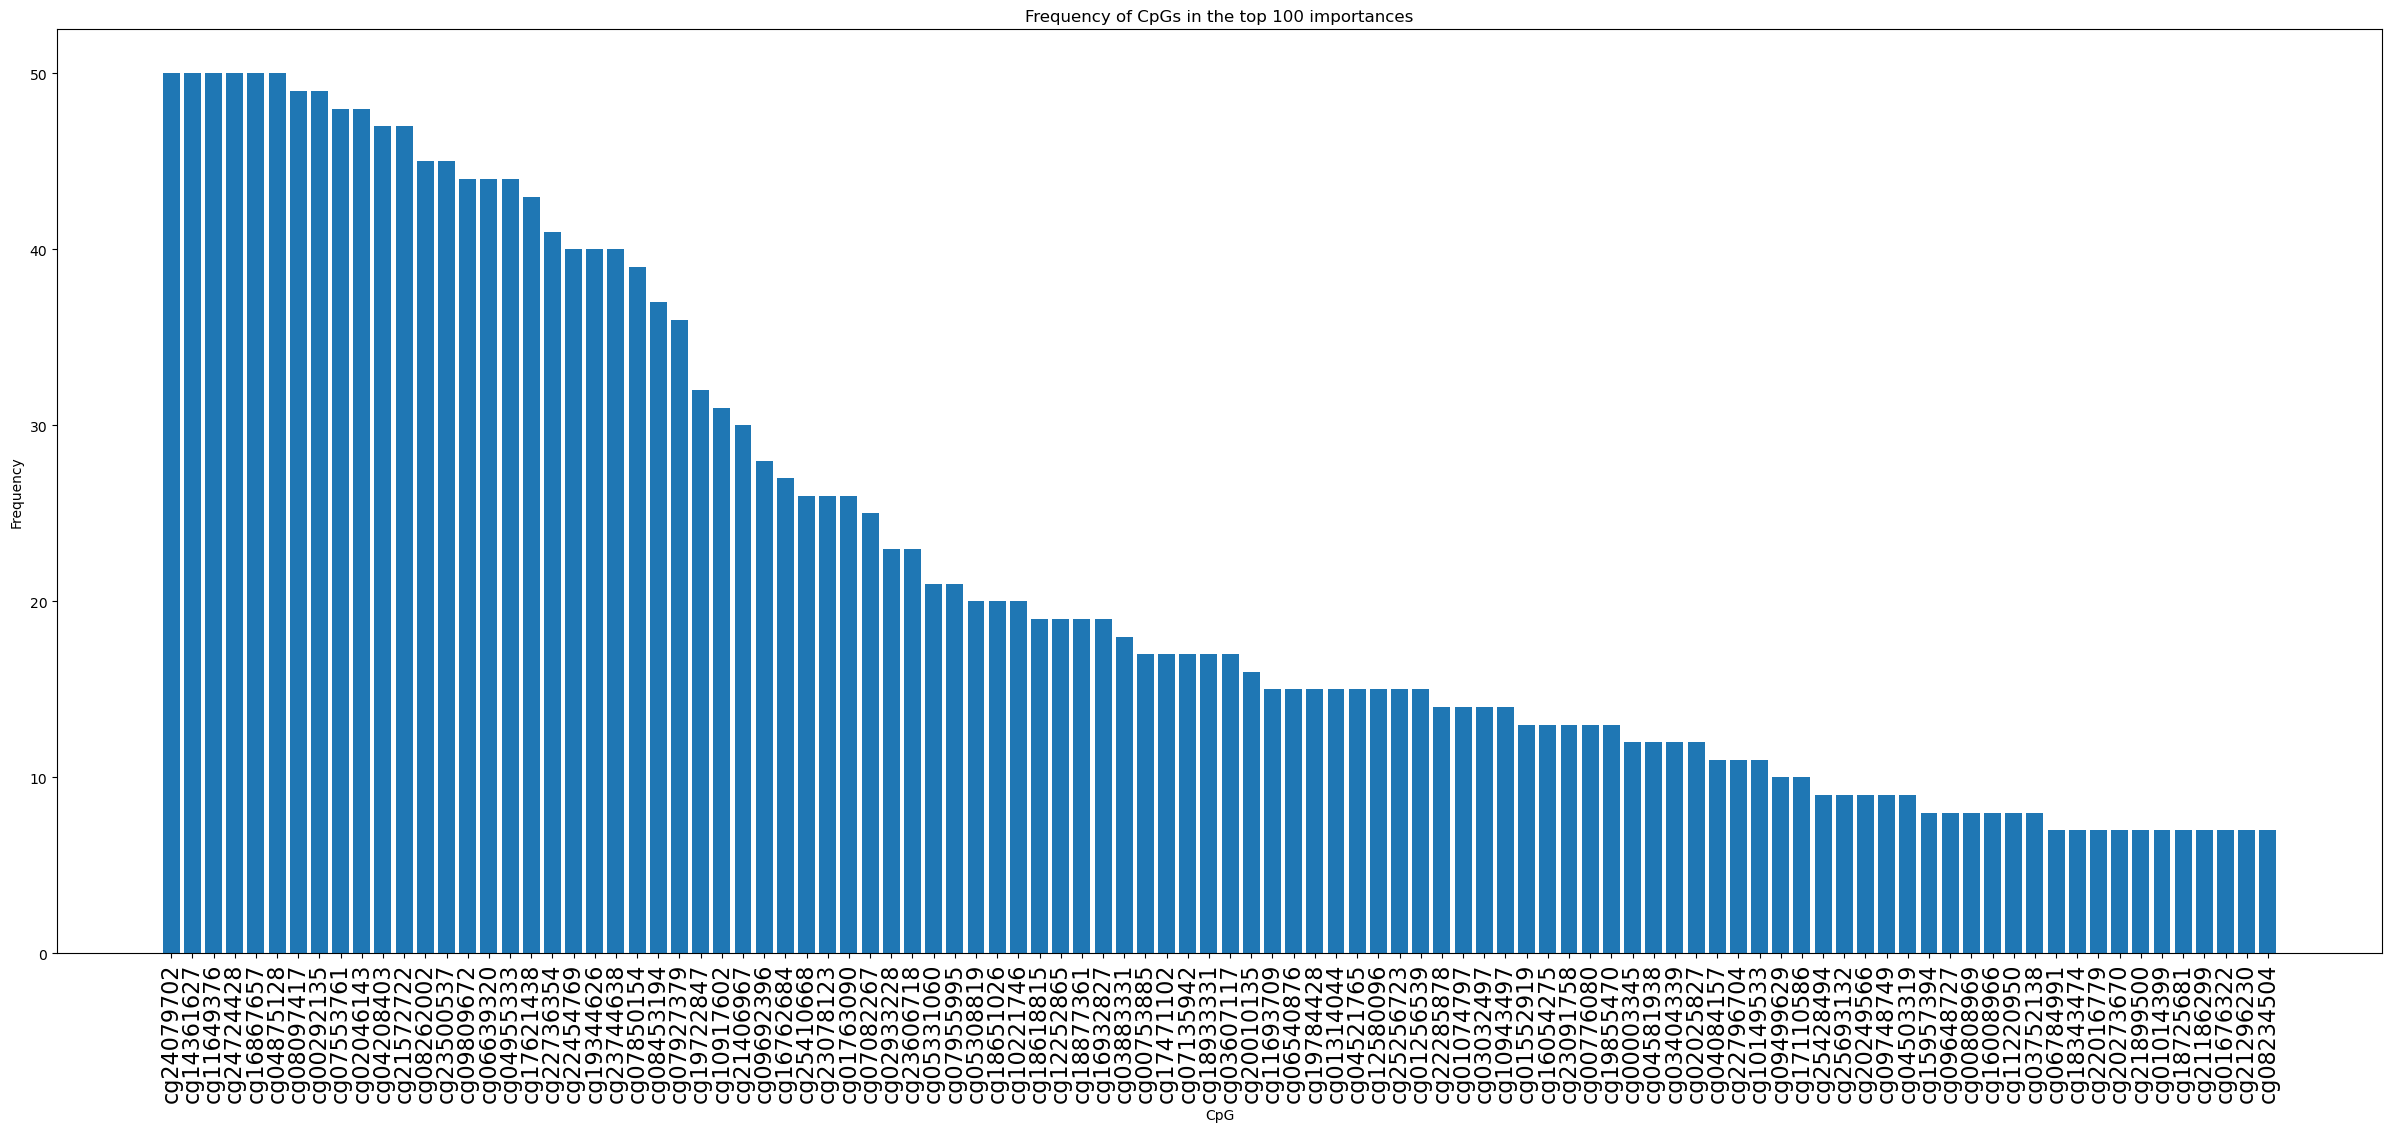

In [39]:
# This function makes a histogram of the frequency of cgs in the top 100 in the 50 trials above
inds, vs, h = histogram_of_top_CpGs_by_importance(df_imp, 100)

In [40]:
cpgs_XGboost_ranked = h.index.values

In [41]:
cpgs_XGboost_ranked

array(['cg24079702', 'cg14361627', 'cg11649376', ..., 'cg01588546',
       'cg10140240', 'cg12948524'], dtype=object)

In [42]:
# Run linear regression CV=100  nukmber of times for each number of cpgs in the num_cpgs list
# and record metrics.

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

CV=100

alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
mod = mod = RidgeCV(alphas=alphas,cv=5)
    
num_cpgs = [10, 20, 30, 50, 100,200,500,1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
y = df_p_working_imp.age
mean_mses = []
mean_rmses = []
mean_maes = []
mean_r2s = []
mean_rsquaes = []
std_mses = []
std_rmses = []
std_maes = []
std_r2s = []
std_rsquaes = []
for num in num_cpgs:
    X = df_p_working_imp[h.index[:num]]
    mses = []
    rmses = []
    maes = []
    r2s = []
    rsquaes = []
    for i in range(CV):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
        eval_set = [(X_train, y_train),(X_test, y_test)]
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        MSE = mean_squared_error(y_test, y_pred)
        rMSE = mean_squared_error(y_test, y_pred, squared=False)
        MAE = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mses.append(MSE)
        rmses.append(rMSE)
        maes.append(MAE)
        r2s.append(r2)
    mean_mses.append(np.array(mses).mean())
    mean_rmses.append(np.array(rmses).mean())
    mean_maes.append(np.array(maes).mean())
    mean_r2s.append(np.array(r2s).mean())
    std_mses.append(np.array(mses).std())
    std_rmses.append(np.array(rmses).std())
    std_maes.append(np.array(maes).std())
    std_r2s.append(np.array(r2s).std())
    print(f'\nThe top {num} cpgs where used, CV={CV}')
    print(f'mean MSE = {np.array(mses).mean():.3f} ± {np.array(mses).std()/(CV**0.5):.3f} ste')
    print(f'mean rMSE = {np.array(rmses).mean():.3f} ± {np.array(rmses).std()/(CV**0.5):.3f} ste')
    print(f'mean MAE = {np.array(maes).mean():.3f} ± {np.array(maes).std()/(CV**0.5):.3f} ste')
    print(f'mean r2 = {np.array(r2s).mean():.3f} ± {np.array(r2s).std()/(CV**0.5):.3f} ste')


The top 10 cpgs where used, CV=100
mean MSE = 40.617 ± 0.416 ste
mean rMSE = 6.365 ± 0.032 ste
mean MAE = 4.716 ± 0.018 ste
mean r2 = 0.903 ± 0.001 ste

The top 20 cpgs where used, CV=100
mean MSE = 33.642 ± 0.358 ste
mean rMSE = 5.792 ± 0.031 ste
mean MAE = 4.198 ± 0.019 ste
mean r2 = 0.920 ± 0.001 ste

The top 30 cpgs where used, CV=100
mean MSE = 31.634 ± 0.340 ste
mean rMSE = 5.616 ± 0.030 ste
mean MAE = 4.070 ± 0.018 ste
mean r2 = 0.925 ± 0.001 ste

The top 50 cpgs where used, CV=100
mean MSE = 29.334 ± 0.330 ste
mean rMSE = 5.408 ± 0.030 ste
mean MAE = 3.919 ± 0.016 ste
mean r2 = 0.930 ± 0.001 ste

The top 100 cpgs where used, CV=100
mean MSE = 27.927 ± 0.352 ste
mean rMSE = 5.274 ± 0.033 ste
mean MAE = 3.803 ± 0.017 ste
mean r2 = 0.934 ± 0.001 ste

The top 200 cpgs where used, CV=100
mean MSE = 26.607 ± 0.331 ste
mean rMSE = 5.148 ± 0.032 ste
mean MAE = 3.700 ± 0.015 ste
mean r2 = 0.937 ± 0.001 ste

The top 500 cpgs where used, CV=100
mean MSE = 25.140 ± 0.363 ste
mean rMSE = 5

In [54]:
num_s = ['10', '20', '30', '50', '100','200','500','1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000']

In [55]:
len(mean_rmses)
#plt.bar(num_s, mean_rmses, yerr = ystes)

18

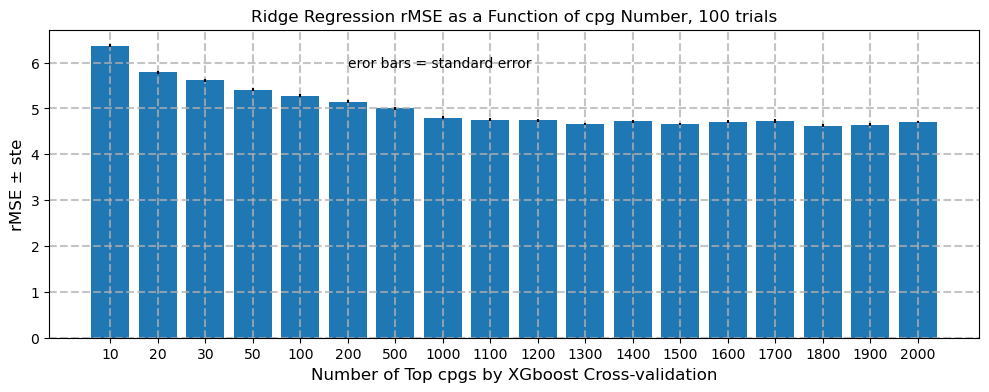

In [56]:
fz = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_rmses)/CV**0.5
plt.bar(num_s, mean_rmses, yerr = ystes)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.ylabel('rMSE ± ste', fontsize = fz)
plt.title('Ridge Regression rMSE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error ', (5, 5.9), fontsize=10)
plt.show()

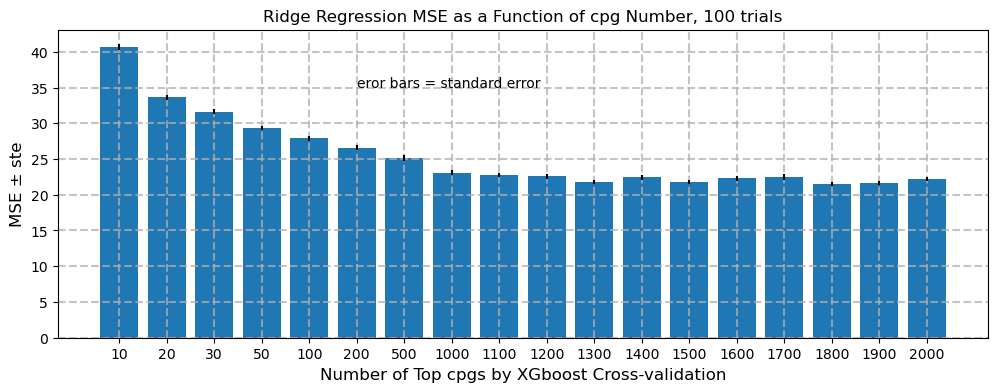

In [57]:
fz = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_mses)/CV**0.5
plt.bar(num_s, mean_mses, yerr = ystes)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.ylabel('MSE ± ste', fontsize = fz)
plt.title('Ridge Regression MSE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (5, 35), fontsize=10)
plt.show()

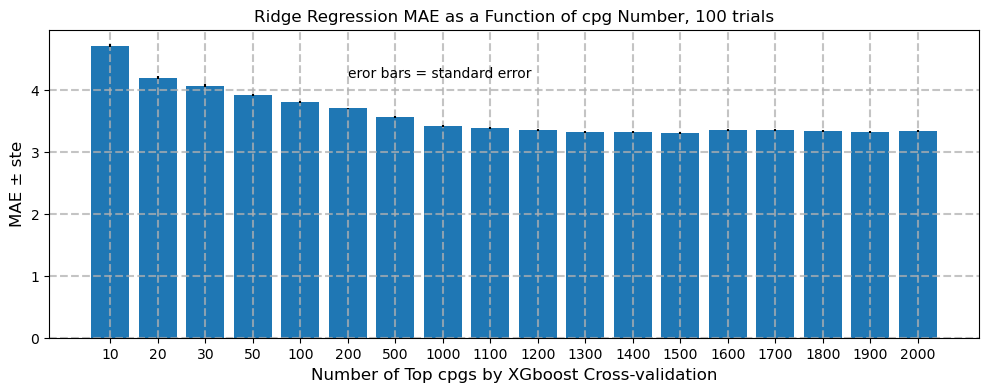

In [58]:
fz = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_maes)/CV**0.5
plt.bar(num_s, mean_maes, yerr = ystes)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.ylabel('MAE ± ste', fontsize = fz)
plt.title('Ridge Regression MAE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (5, 4.2), fontsize=10)
plt.show()

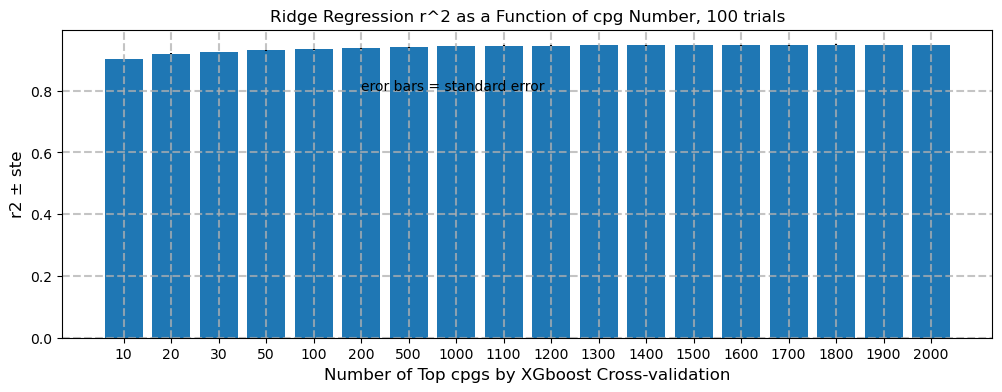

In [59]:
fz = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_r2s)/CV**0.5
plt.bar(num_s, mean_r2s, yerr = ystes)
plt.ylabel('r2 ± ste', fontsize = fz)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.title('Ridge Regression r^2 as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (5, 0.8), fontsize=10)
plt.show()

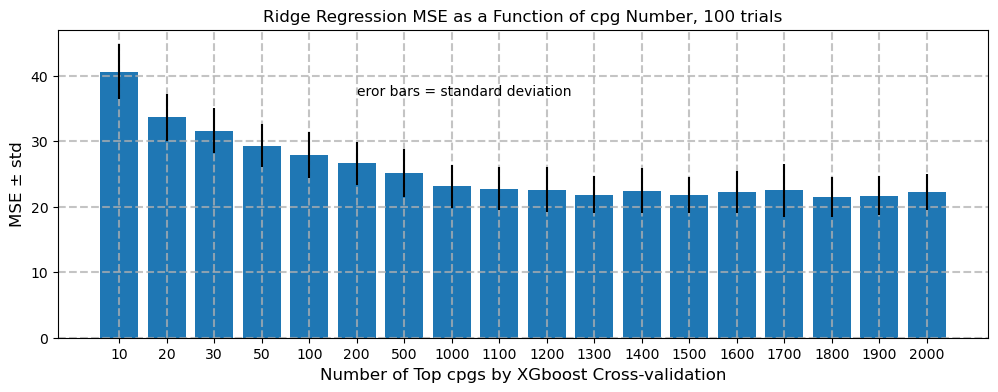

In [60]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_mses)
plt.bar(num_s, mean_mses, yerr = ystes)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.ylabel('MSE ± std', fontsize = fz)
plt.title('Ridge Regression MSE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard deviation', (5, 37), fontsize=10)
plt.show()

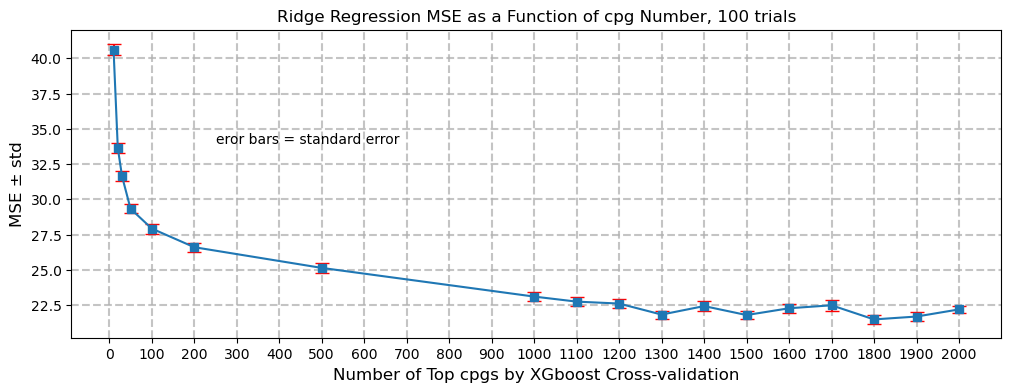

In [61]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_mses)/CV**0.5
plt.errorbar(num_cpgs, mean_mses, marker='s', ecolor='r', yerr = ystes,capsize=5)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.xticks(range(0,2100,100))
plt.ylabel('MSE ± std', fontsize = fz)
plt.title('Ridge Regression MSE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (250, 34), fontsize=10)
plt.show()

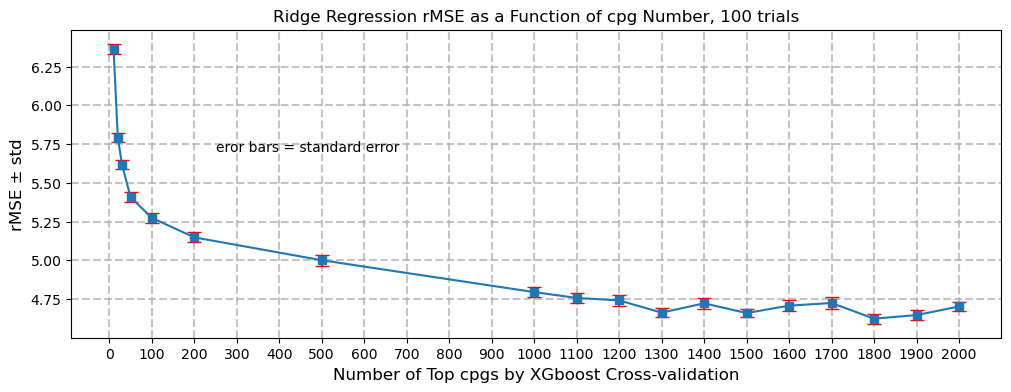

In [62]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_rmses)/CV**0.5
plt.errorbar(num_cpgs, mean_rmses, marker='s', ecolor='r', yerr = ystes,capsize=5)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.xticks(range(0,2100,100))
plt.ylabel('rMSE ± std', fontsize = fz)
plt.title('Ridge Regression rMSE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (250, 5.7), fontsize=10)
plt.show()

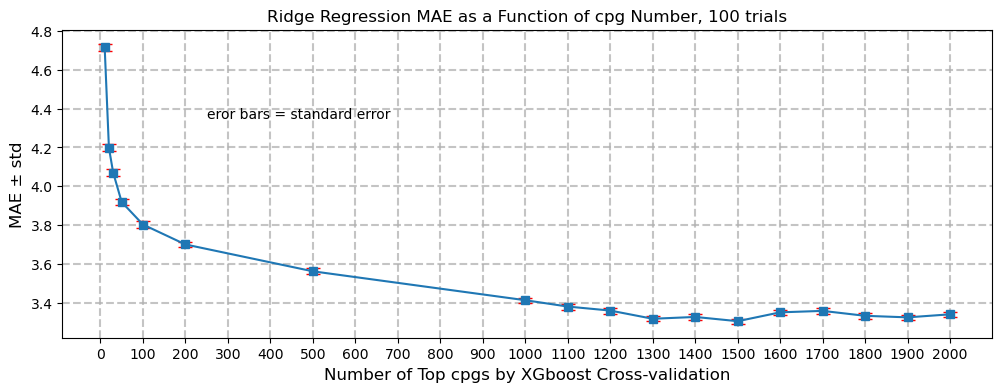

In [63]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_maes)/CV**0.5
plt.errorbar(num_cpgs, mean_maes, marker='s', ecolor='r', yerr = ystes,capsize=5)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.xticks(range(0,2100,100))
plt.ylabel('MAE ± std', fontsize = fz)
plt.title('Ridge Regression MAE as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (250, 4.35), fontsize=10)
plt.show()

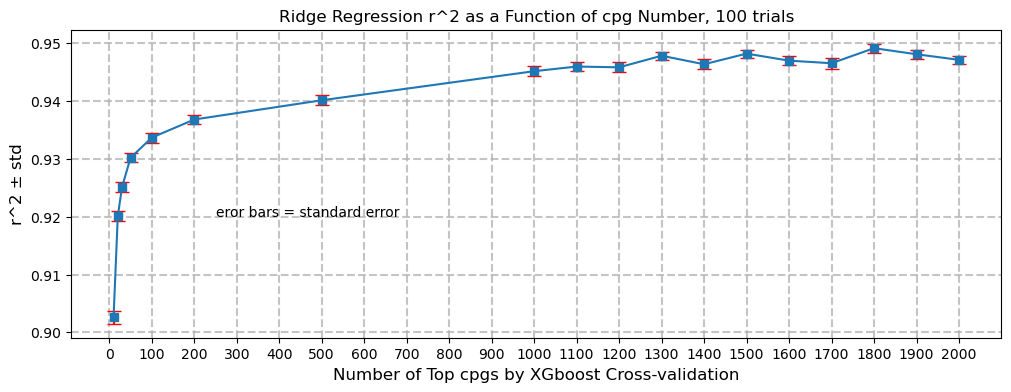

In [64]:
z = 12
plt.rcdefaults()
plt.figure(figsize=(12, 4))
ystes = np.array(std_r2s)/CV**0.5
plt.errorbar(num_cpgs, mean_r2s, marker='s', ecolor='r', yerr = ystes,capsize=5)
plt.xlabel('Number of Top cpgs by XGboost Cross-validation', fontsize = fz)
plt.xticks(range(0,2100,100))
plt.ylabel('r^2 ± std', fontsize = fz)
plt.title('Ridge Regression r^2 as a Function of cpg Number, 100 trials', fontsize = fz)
plt.grid(True, lw=1.5, ls='--', alpha=0.75)
plt.annotate('eror bars = standard error', (250, 0.92), fontsize=10)
plt.show()